# Data Missingness Treatment

In [1]:
if(!require(dplyr)) {install.packages("dplyr");require(dplyr)}
if(!require(ggplot2)) {install.packages("ggplot2");require(ggplot2)}
if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}
if(!require(DBI)){install.packages("DBI"); require(DBI)}
if(!require(RSQLite)){install.packages("RSQLite"); require(RSQLite)}
if(!require(funModeling)){install.packages("funModeling"); require(funModeling)}
if(!require(tidyr)){install.packages("tidyr"); require(tidyr)}
if(!require(NbClust)) {install.packages("NbClust");require(NbClust)}

Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2
Loading required package: ggExtra
Warning message:
"package 'ggExtra' was built under R version 3.5.2"Loading required package: naniar
Warning message:
"package 'naniar' was built under R version 3.5.2"Loading required package: mvoutlier
Loading required package: sgeostat
sROC 0.1-2 loaded
Loading required package: MissMech
Warning message:
"package 'MissMech' was built under R version 3.5.2"Loading required package: mice
Loading required package: lattice

Attaching package: 'mice'

The following objects are masked from 'package:base':

    cbind, rbind

Loading required package: MatchIt
Warning message:
"package 'MatchIt' was built under R version 3.5.2"Loading required package: DBI
Loading required package: RSQLite
Loading r

In [2]:
missingMatrix <- function(data) {
    vn <- names(data)
    missdata <- data.frame(row1=1:nrow(data))
    for(v in vn) {
        newn <- paste0(v,"_na")
        mv <- ifelse(is.na(data[[v]]),1,0)
        missdata[newn] <- mv
    }
    missdata$row1 <- NULL
    return(missdata)
}

minmax <- function(x) {
    return(((x-min(x,na.rm=T))/(max(x,na.rm=T)-min(x,na.rm=T))))
}

getMissingness <- function (data, getRows = FALSE) {
    require(dplyr)
    l <- nrow(data)
    vn <- names(data)
    nadf <- data
    cnt <- NULL
    miss <- function(x) return(sum(is.na(x)))
    for (n in vn) {
        nadf[[n]] <- ifelse(is.na(nadf[[n]]) == T, 1, 0)
        cnt <- rbind(cnt, data.frame(n, sum(nadf[[n]])))
    }
    names(cnt) <- c("var", "na.count")
    cnt$rate <- round((cnt$na.count/nrow(nadf)) * 100, 1)
    nadf$na.cnt <- 0
    nadf$na.cnt <- rowSums(nadf)
    cnt <- cnt %>% dplyr::arrange(desc(na.count)) %>% dplyr::filter(na.count > 
        0)
    totmiss <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::tally()
    idx <- NULL
    msg <- (paste("This dataset has ", as.character(totmiss), 
        " (", as.character(round(totmiss/nrow(data) * 100, 1)), 
        "%)", " complete rows. Original data has ", nrow(data), 
        " rows.", sep = ""))
    if (getRows == TRUE & totmiss != 0) {
        nadf$rn <- seq_len(nrow(data))
        idx <- nadf %>% dplyr::filter(na.cnt == 0) %>% dplyr::select(rn)
    }
    print(list(head(cnt, n = 10), msg))
    return(list(missingness = cnt, message = msg, rows = idx$rn))
}

In [3]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################
            
#### Read function to import data from the SQL to a pandas dataframe.
readSQL <- function(query, db=DB_FILE) {
    require(DBI)
    require(RSQLite)
    con <- dbConnect(SQLite(), DB_FILE)
    df <- dbGetQuery(con, query)
    return(df)
}
#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
writeSQL <- function(df,tablename,overwrite=FALSE, append=FALSE,db=DB_FILE) {
    require(DBI)
    require(RSQLite)
    con <- dbConnect(SQLite(), DB_FILE)
    dbWriteTable(con,tablename,df,overwrite,append)
}
####

In [4]:
### load data
DB_FILE = paste0(getwd(),"/Data/loans.db") 
loans = readSQL("SELECT * FROM loans_dataset_outliers")


In [5]:
dim(loans)
head(loans)

[1] 254794     66

verification_status,issue_d,pymnt_plan,purpose,initial_list_status,emp_length,loan_amnt,funded_amnt,funded_amnt_inv,term,...,annual_inc_rt,inc_grp,revol_bal_rt,credit_hist_log,credit_hist_rt,credit_hist_grp,max_L,max_fund_L,MAX_fund_L_inv,is_acc_now_delinq_not_zero
Not Verified,2007-10-01,0,debt_consolidation,1,2 years,10000,10000,2175.000,0,...,190.7878,verylow_inc,95.73923,2.397895,3.316625,4-13_yrs,0,0,0,0
Not Verified,2007-12-01,0,credit_card,1,1 year,5400,5400,375.000,0,...,204.9390,verylow_inc,195.07434,2.079442,2.828427,4-13_yrs,0,0,0,0
Not Verified,2007-11-01,0,debt_consolidation,1,2 years,1500,1500,583.050,0,...,124.9000,verylow_inc,79.44810,1.945910,2.645751,4-13_yrs,0,0,0,0
Not Verified,2007-12-01,0,home_improvement,1,6 years,4800,4800,1550.000,0,...,244.9490,low_inc,53.12250,2.397895,3.316625,4-13_yrs,0,0,0,0
Not Verified,2007-10-01,0,debt_consolidation,1,< 1 year,4800,4800,1625.000,0,...,158.1139,verylow_inc,20.22375,2.302585,3.162278,4-13_yrs,0,0,0,0
Not Verified,2007-10-01,0,other,1,1 year,4200,4200,1125.002,0,...,154.9193,verylow_inc,0.00000,2.708050,3.872983,13-17_yrs,0,0,0,0


In [6]:
copy1<-loans

In [7]:
split(names(loans),sapply(loans, function(x) paste(class(x), collapse=" ")))

$character
 [1] "verification_status"            "issue_d"                       
 [3] "pymnt_plan"                     "purpose"                       
 [5] "initial_list_status"            "emp_length"                    
 [7] "term"                           "home_ownership"                
 [9] "default"                        "full_state"                    
[11] "cat_delinq_2yrs"                "cat_inq_last_6mths"            
[13] "cat_collections_12_mths_ex_med" "cat_pub_rec"                   
[15] "inc_grp"                        "credit_hist_grp"               

$integer
 [1] "loan_amnt"                   "funded_amnt"                
 [3] "collections_12_mths_ex_med"  "mths_since_last_major_derog"
 [5] "delinq_2yrs"                 "acc_now_delinq"             
 [7] "inq_last_6mths"              "mths_since_last_delinq"     
 [9] "mths_since_last_record"      "open_acc"                   
[11] "pub_rec"                     "total_acc"                  
[13] "tot_coll_amt"                "open_acc_6m"                
[15] "open_il_6m"                  "open_il_12m"                
[17] "open_il_24m"                 "mths_since_rcnt_il"         
[19] "total_bal_il"                "open_rv_12m"                
[21] "open_rv_24m"                 "max_bal_bc"                 
[23] "inq_fi"                      "total_cu_tl"                
[25] "inq_last_12m"                "credit_hist"                

$numeric
 [1] "funded_amnt_inv"            "annual_inc"                
 [3] "dti"                        "revol_bal"                 
 [5] "revol_util"                 "tot_cur_bal"               
 [7] "il_util"                    "all_util"                  
 [9] "total_rev_hi_lim"           "loan_installment"          
[11] "acc_ratio"                  "poverty_rate_p"            
[13] "mths_since_last_delinq_rt"  "open_acc_rt"               
[15] "total_acc_rt"               "annual_inc_log"            
[17] "annual_inc_rt"              "revol_bal_rt"              
[19] "credit_hist_log"            "credit_hist_rt"            
[21] "max_L"                      "max_fund_L"                
[23] "MAX_fund_L_inv"             "is_acc_now_delinq_not_zero"

In [8]:
loans$verification_status <-as.numeric(as.factor(loans$verification_status))
loans$purpose <-as.numeric(as.factor(loans$purpose))
loans$emp_length <-as.numeric(as.factor(loans$emp_length))
loans$home_ownership <-as.numeric(as.factor(loans$home_ownership))
loans$term <-as.factor(loans$term)
loans$pymnt_plan <-as.factor(loans$pymnt_plan)
loans$initial_list_status <-as.factor(loans$initial_list_status)
loans$full_state <-as.numeric(as.factor(loans$full_state))
loans$issue_d <- as.Date(loans$issue_d)
loans$default <- factor(loans$default)
loans$cat_delinq_2yrs <-as.numeric(as.factor(loans$cat_delinq_2yrs))
loans$cat_inq_last_6mths <-as.numeric(as.factor(loans$cat_inq_last_6mths))
loans$cat_collections_12_mths_ex_med <-as.numeric(as.factor(loans$cat_collections_12_mths_ex_med))
loans$cat_pub_rec <-as.numeric(as.factor(loans$cat_pub_rec))
loans$inc_grp <-as.numeric(as.factor(loans$inc_grp))
loans$credit_hist_grp <-as.numeric(as.factor(loans$credit_hist_grp))

In [9]:
## numeric variables
num_vars <- 
  loans %>% 
  sapply(is.numeric) %>% 
  which() %>% 
  names()
num_vars

[1] "verification_status"            "purpose"                       
 [3] "emp_length"                     "loan_amnt"                     
 [5] "funded_amnt"                    "funded_amnt_inv"               
 [7] "collections_12_mths_ex_med"     "mths_since_last_major_derog"   
 [9] "home_ownership"                 "annual_inc"                    
[11] "dti"                            "delinq_2yrs"                   
[13] "acc_now_delinq"                 "inq_last_6mths"                
[15] "mths_since_last_delinq"         "mths_since_last_record"        
[17] "open_acc"                       "pub_rec"                       
[19] "revol_bal"                      "revol_util"                    
[21] "total_acc"                      "tot_coll_amt"                  
[23] "tot_cur_bal"                    "open_acc_6m"                   
[25] "open_il_6m"                     "open_il_12m"                   
[27] "open_il_24m"                    "mths_since_rcnt_il"            
[29] "total_bal_il"                   "il_util"                       
[31] "open_rv_12m"                    "open_rv_24m"                   
[33] "max_bal_bc"                     "all_util"                      
[35] "total_rev_hi_lim"               "inq_fi"                        
[37] "total_cu_tl"                    "inq_last_12m"                  
[39] "loan_installment"               "full_state"                    
[41] "acc_ratio"                      "credit_hist"                   
[43] "poverty_rate_p"                 "cat_delinq_2yrs"               
[45] "cat_inq_last_6mths"             "cat_collections_12_mths_ex_med"
[47] "cat_pub_rec"                    "mths_since_last_delinq_rt"     
[49] "open_acc_rt"                    "total_acc_rt"                  
[51] "annual_inc_log"                 "annual_inc_rt"                 
[53] "inc_grp"                        "revol_bal_rt"                  
[55] "credit_hist_log"                "credit_hist_rt"                
[57] "credit_hist_grp"                "max_L"                         
[59] "max_fund_L"                     "MAX_fund_L_inv"                
[61] "is_acc_now_delinq_not_zero"

## Missing values visualization

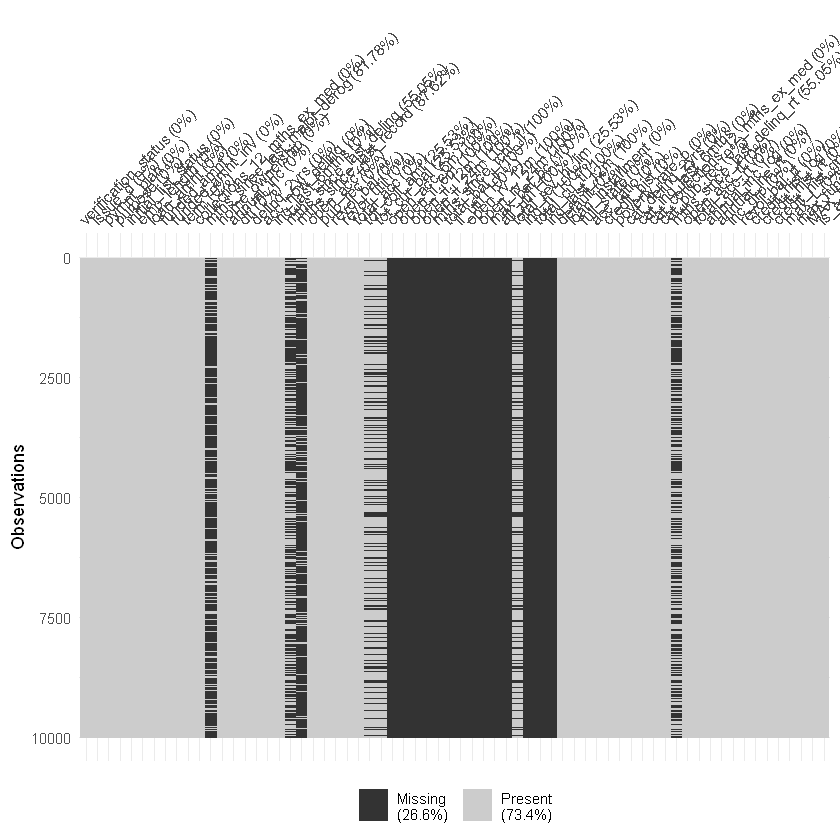

In [10]:
loans %>%
  sample_n(10000) %>%
  vis_miss()

In [13]:
getMissingness(loans)

[[1]]
                  var na.count rate
1         open_acc_6m   254794  100
2          open_il_6m   254794  100
3         open_il_12m   254794  100
4         open_il_24m   254794  100
5  mths_since_rcnt_il   254794  100
6        total_bal_il   254794  100
7             il_util   254794  100
8         open_rv_12m   254794  100
9         open_rv_24m   254794  100
10         max_bal_bc   254794  100

[[2]]
[1] "This dataset has 0 (0%) complete rows. Original data has 254794 rows."



var,na.count,rate
open_acc_6m,254794,100.0
open_il_6m,254794,100.0
open_il_12m,254794,100.0
open_il_24m,254794,100.0
mths_since_rcnt_il,254794,100.0
total_bal_il,254794,100.0
il_util,254794,100.0
open_rv_12m,254794,100.0
open_rv_24m,254794,100.0
max_bal_bc,254794,100.0


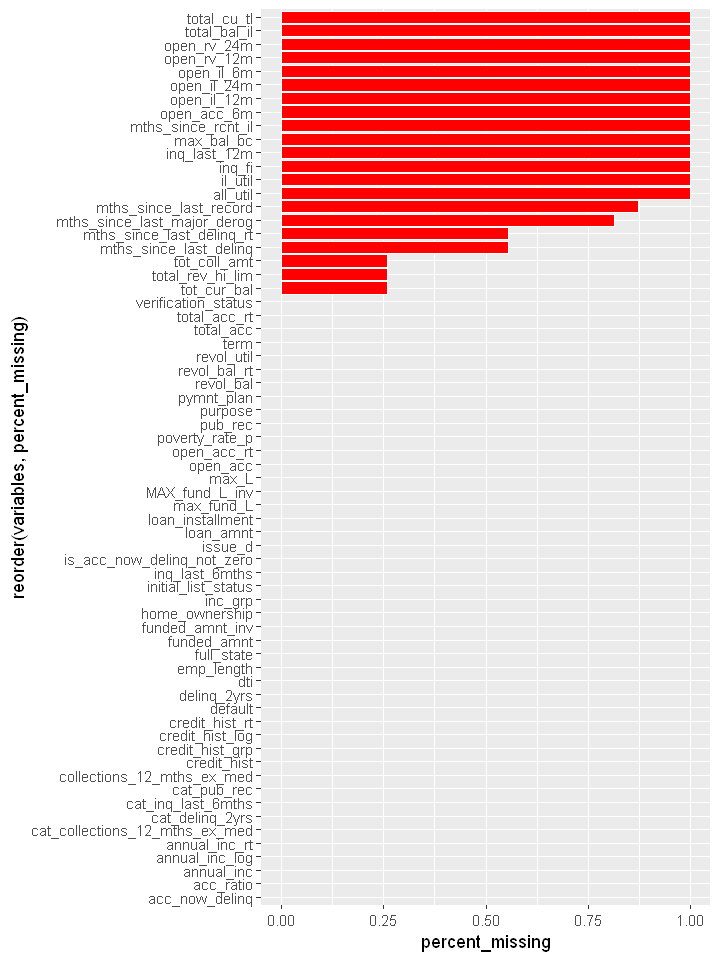

In [14]:
options(repr.plot.width=6, repr.plot.height=8)
missing_data <- loans %>% summarise_all(funs(sum(is.na(.))/n()))
missing_data <- gather(missing_data, key = "variables", value = "percent_missing") 
ggplot(missing_data, aes(x = reorder(variables, percent_missing), y = percent_missing)) +
  geom_bar(stat = "identity", fill = "red", aes(color = I('white')), size = 0.1)+coord_flip()

## Determinate the Missingness Generation Mechanism
 
There are three mechanisms that generate Missing values:
 
1. Missing Completely at Random (MCAR)
2. Missing at Random (MAR)
3. Missing not at Random (MNAR)
 


# Missingness

We creating for each feature a dummy column that indicates if is na

In [10]:
missingcols_dummy <- missingMatrix(loans)

In [11]:
head(missingcols_dummy)

verification_status_na,issue_d_na,pymnt_plan_na,purpose_na,initial_list_status_na,emp_length_na,loan_amnt_na,funded_amnt_na,funded_amnt_inv_na,term_na,...,annual_inc_rt_na,inc_grp_na,revol_bal_rt_na,credit_hist_log_na,credit_hist_rt_na,credit_hist_grp_na,max_L_na,max_fund_L_na,MAX_fund_L_inv_na,is_acc_now_delinq_not_zero_na
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
##function creates logistic Regression Model
createLogisticRegressionModel <- function (dt,predictCol,dependCols,family="binomial"){
  glmod <- glm(as.formula(paste(predictCol,paste("~", dependCols))), data=dt,family = family,control = list(maxit = 50))
  #print(summary(glmod))
  return(glmod)
}

In [13]:
## function to determine the missing mechanism
defineMissingMechanism<- function(mod){
    m<- coef(summary(mod))
    important<- subset(m, m[,4] <0.05)
    important_cnt <- nrow(important)
    #print(paste0("Number of Significant variables = ",important_cnt))
    mech<-NULL
    important_names<-''
    if (important_cnt > 1) {
       # print("MNAR")
        mech <- "MNAR"
    } else if (important_cnt == 0) {
        #print("MCAR")
        mech <- "MCAR"
        } else{
            #print("Need to check further if MCAR or MAR")
            mech <- "Need to check further if MCAR or MAR"
            important_names <- rownames(important)
            #print(important)
        }
    return(list(mech = mech, important_cnt = important_cnt,important_names = important_names))
}

Define the full and the missing columns of our dataset

In [14]:
missingVars <- colnames(loans)[colSums(is.na(loans)) > 0]
#missingVars <- missingVars[!missingVars %in% c("last_credit_pull_d","earliest_cr_line")]
missingVars

fullVars <- colnames(loans)[colSums(is.na(loans)) == 0]
fullVars <- fullVars[!fullVars %in% c("issue_d")]
fullVars

[1] "mths_since_last_major_derog" "mths_since_last_delinq"     
 [3] "mths_since_last_record"      "tot_coll_amt"               
 [5] "tot_cur_bal"                 "open_acc_6m"                
 [7] "open_il_6m"                  "open_il_12m"                
 [9] "open_il_24m"                 "mths_since_rcnt_il"         
[11] "total_bal_il"                "il_util"                    
[13] "open_rv_12m"                 "open_rv_24m"                
[15] "max_bal_bc"                  "all_util"                   
[17] "total_rev_hi_lim"            "inq_fi"                     
[19] "total_cu_tl"                 "inq_last_12m"               
[21] "mths_since_last_delinq_rt"

[1] "verification_status"            "pymnt_plan"                    
 [3] "purpose"                        "initial_list_status"           
 [5] "emp_length"                     "loan_amnt"                     
 [7] "funded_amnt"                    "funded_amnt_inv"               
 [9] "term"                           "collections_12_mths_ex_med"    
[11] "home_ownership"                 "annual_inc"                    
[13] "dti"                            "delinq_2yrs"                   
[15] "acc_now_delinq"                 "inq_last_6mths"                
[17] "open_acc"                       "pub_rec"                       
[19] "revol_bal"                      "revol_util"                    
[21] "total_acc"                      "default"                       
[23] "loan_installment"               "full_state"                    
[25] "acc_ratio"                      "credit_hist"                   
[27] "poverty_rate_p"                 "cat_delinq_2yrs"               
[29] "cat_inq_last_6mths"             "cat_collections_12_mths_ex_med"
[31] "cat_pub_rec"                    "open_acc_rt"                   
[33] "total_acc_rt"                   "annual_inc_log"                
[35] "annual_inc_rt"                  "inc_grp"                       
[37] "revol_bal_rt"                   "credit_hist_log"               
[39] "credit_hist_rt"                 "credit_hist_grp"               
[41] "max_L"                          "max_fund_L"                    
[43] "MAX_fund_L_inv"                 "is_acc_now_delinq_not_zero"

In [15]:
##Function That run through all the missing variables and check the missing mechanism and possible action
getMissingTreatment <- function (data,missingcols_dummy,missingVars,fullVars) {
missDF <- NULL
for (v in missingVars) {
    print(v)
    print(format(Sys.time(), "%X"))
    naName <- paste0(v,"_na")
    dfNames<-c(fullVars,naName)
    df <- cbind(loans[,fullVars],missingcols_dummy[[naName]])
    colnames(df) <- dfNames
    na.count <- sum(missingcols_dummy[[naName]])
    na.rate <- round((na.count/nrow(missingcols_dummy)) * 100, 1)
    mod <- createLogisticRegressionModel(df,naName,".")
    model_res <- defineMissingMechanism(mod)
    mech <- model_res$mech
    if (mech =="MCAR" && na.rate == 100.0){
        mech = "MNAR"
    }
    important_cnt <- model_res$important_cnt
    important_names <- model_res$important_names
    action <- NULL
    #print(na.count)
    #print(na.rate)
    if (mech =="MNAR" && na.rate>3){
        #print ("Drop Column")
        action <- "Drop Column"
        } else if (mech =="MNAR" && na.rate<3){
        #print ("Drop Rows")
         action <- "Drop Rows"
    }else{
        #print ("Can Do Imputation")
        action <- "Can Do Imputation"
        } 
        missDF <- rbind(missDF, data.frame(v,na.count,na.rate,mech,important_cnt,important_names,action))
    }
    names(missDF) <- c("var", "na.count", "na.rate","missing mechanism","siginificant vars count","siginificant vars","possible action")
return(missDF)
}

In [17]:
missDF <- getMissingTreatment(loans,missingcols_dummy,missingVars,fullVars)

[1] "mths_since_last_major_derog"
[1] "19:18:52"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "mths_since_last_delinq"
[1] "19:19:01"
[1] "mths_since_last_record"
[1] "19:19:13"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "tot_coll_amt"
[1] "19:19:47"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "tot_cur_bal"
[1] "19:19:59"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "open_acc_6m"
[1] "19:20:15"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "open_il_6m"
[1] "19:20:41"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "open_il_12m"
[1] "19:21:08"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "open_il_24m"
[1] "19:21:34"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "mths_since_rcnt_il"
[1] "19:21:59"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "total_bal_il"
[1] "19:22:25"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "il_util"
[1] "19:22:51"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "open_rv_12m"
[1] "19:23:17"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "open_rv_24m"
[1] "19:23:42"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "max_bal_bc"
[1] "19:24:08"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "all_util"
[1] "19:24:34"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "total_rev_hi_lim"
[1] "19:24:59"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "inq_fi"
[1] "19:25:15"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "total_cu_tl"
[1] "19:25:40"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "inq_last_12m"
[1] "19:26:06"


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

[1] "mths_since_last_delinq_rt"
[1] "19:26:31"


In [18]:
missDF

var,na.count,na.rate,missing mechanism,siginificant vars count,siginificant vars,possible action
mths_since_last_major_derog,207432,81.4,MNAR,34,,Drop Column
mths_since_last_delinq,141632,55.6,MNAR,25,,Drop Column
mths_since_last_record,222601,87.4,MNAR,44,,Drop Column
tot_coll_amt,66095,25.9,MNAR,30,,Drop Column
tot_cur_bal,66094,25.9,MNAR,29,,Drop Column
open_acc_6m,254794,100.0,MNAR,0,,Drop Column
open_il_6m,254794,100.0,MNAR,0,,Drop Column
open_il_12m,254794,100.0,MNAR,0,,Drop Column
open_il_24m,254794,100.0,MNAR,0,,Drop Column
mths_since_rcnt_il,254794,100.0,MNAR,0,,Drop Column


We see that all of the columns have MNAR mechanism, there are columns that have 0 significant variables but they have 100% NA rate therefore they are labeled also as MNAR

In [60]:
#function that treats the missing value in the data
treatMissing <- function (data,missDF) {
    misAction <- missDF%>%select("var","possible action")
    misAction$"possible action"<-as.character(misAction$"possible action")
    i <-1
for (v in misAction$var){
    action <- misAction[i,2]
    print(v)
    #print(action)
        if (action == "Drop Column"){
           # print("Drop Column")
            data <- data%>%select(-one_of(v))
        }
        else if (action == "Drop Rows"){
            #print ("drop rows")
        
            #print ( paste0("numrows before",nrow(data)) )
            data <- data[!is.na(data[[v]]) ,]
            #print ( paste0("numrows after",nrow(data)) )
        }
        else{
          print ("imputation")
        }
        i <- i + 1
    }
    return(data)
}

In [61]:
loans <- copy1
loans2 <- treatMissing(loans,missDF)
dim(loans)
dim(loans2)

[1] "mths_since_last_major_derog"
[1] "mths_since_last_delinq"
[1] "mths_since_last_record"
[1] "tot_coll_amt"
[1] "tot_cur_bal"
[1] "open_acc_6m"
[1] "open_il_6m"
[1] "open_il_12m"
[1] "open_il_24m"
[1] "mths_since_rcnt_il"
[1] "total_bal_il"
[1] "il_util"
[1] "open_rv_12m"
[1] "open_rv_24m"
[1] "max_bal_bc"
[1] "all_util"
[1] "total_rev_hi_lim"
[1] "inq_fi"
[1] "total_cu_tl"
[1] "inq_last_12m"
[1] "mths_since_last_delinq_rt"


[1] 254794     66

[1] 254794     45

In [63]:
##saving table
writeSQL(loans2, "loans_dataset_missing")